In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='3'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
import wandb
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import utils


from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

/tmp/ipykernel_4082370/3268655452.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def pdb():
    import pdb
    pdb.set_trace

In [3]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')
    return count

In [4]:
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

In [5]:
def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

### Pre-training 

In [6]:
#%run main.py --dataset cifar100 --dataroot=data/cifar-100-python --model resnet --filteers 0.4 --lr 0.1 --lossfn ce --num-classes 100

### Metrics

In [7]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,128,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']

    return activations,predictions

In [8]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [9]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

### Membership Inference Attack

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import random

def cm_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred)
    
    FP = cnf_matrix[0][1] 
    FN = cnf_matrix[1][0] 
    TP = cnf_matrix[0][0] 
    TN = cnf_matrix[1][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print (f"FPR:{FPR:.2f}, FNR:{FNR:.2f}, FP{FP:.2f}, TN{TN:.2f}, TP{TP:.2f}, FN{FN:.2f}")
    return ACC


def evaluate_attack_model(sample_loss,
                          members,
                          n_splits = 5,
                          random_state = None):
  """Computes the cross-validation score of a membership inference attack.
  Args:
    sample_loss : array_like of shape (n,).
      objective function evaluated on n samples.
    members : array_like of shape (n,),
      whether a sample was used for training.
    n_splits: int
      number of splits to use in the cross-validation.
    random_state: int, RandomState instance or None, default=None
      random state to use in cross-validation splitting.
  Returns:
    score : array_like of size (n_splits,)
  """

  unique_members = np.unique(members)
  if not np.all(unique_members == np.array([0, 1])):
    raise ValueError("members should only have 0 and 1s")

  attack_model = LogisticRegression()
  cv = StratifiedShuffleSplit(
      n_splits=n_splits, random_state=random_state)
  return cross_val_score(attack_model, sample_loss, members, cv=cv, scoring=cm_score)

def membership_inference_attack(model, t_loader, f_loader, seed):
    import matplotlib.pyplot as plt
    import seaborn as sns
    

    fgt_cls = list(np.unique(f_loader.dataset.targets))
    indices = [i in fgt_cls for i in t_loader.dataset.targets]
    t_loader.dataset.data = t_loader.dataset.data[indices]
    t_loader.dataset.targets = t_loader.dataset.targets[indices]

    
    cr = nn.CrossEntropyLoss(reduction='none')
    test_losses = []
    forget_losses = []
    model.eval()
    mult = 0.5 if args.lossfn=='mse' else 1
    dataloader = torch.utils.data.DataLoader(t_loader.dataset, batch_size=128, shuffle=False)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*cr(output, target)
        test_losses = test_losses + list(loss.cpu().detach().numpy())
    del dataloader
    dataloader = torch.utils.data.DataLoader(f_loader.dataset, batch_size=128, shuffle=False)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*cr(output, target)
        forget_losses = forget_losses + list(loss.cpu().detach().numpy())
    del dataloader

    np.random.seed(seed)
    random.seed(seed)
    if len(forget_losses) > len(test_losses):
        forget_losses = list(random.sample(forget_losses, len(test_losses)))
    elif len(test_losses) > len(forget_losses):
        test_losses = list(random.sample(test_losses, len(forget_losses)))
    
    
    fig, ax = plt.subplots()
    sns.histplot(np.array(test_losses), kde=False, label='test-loss', ax=ax)
    sns.histplot(np.array(forget_losses), kde=False, label='forget-loss', ax=ax)
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title("loss histograms",size=18)
    plt.xlabel('loss values',size=14)
    plt.show()
    print (np.max(test_losses), np.min(test_losses))
    print (np.max(forget_losses), np.min(forget_losses))


    test_labels = [0]*len(test_losses)
    forget_labels = [1]*len(forget_losses)
    features = np.array(test_losses + forget_losses).reshape(-1,1)
    labels = np.array(test_labels + forget_labels).reshape(-1)
    features = np.clip(features, -100, 100)
    score = evaluate_attack_model(features, labels, n_splits=5, random_state=seed)

    return score


### Finetune and Fisher Helper

In [11]:
from utils import *
def get_metrics(model,dataloader,criterion,bs=128,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=128, shuffle=False)
    model.eval()
    metrics = utils.AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            #activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            activations = activations + list(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [12]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = utils.AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = utils.AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [13]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def negative_grad(model: nn.Module, retain_dataset, forget_dataset, quiet=False, args=None):
    args.ng_alpha = 0.9999
    args.ng_epochs = 5
    args.ng_lr = 0.0001
    args.ng_retain_bs = 128
    args.ng_forget_bs = 128
    alpha, epochs, lr =args.ng_alpha, args.ng_epochs, args.ng_lr
    
    retain_loader = replace_loader_dataset(None, retain_dataset, batch_size=args.ng_retain_bs, seed=args.seed, shuffle=True)
    forget_loader = replace_loader_dataset(None, forget_dataset, batch_size=args.ng_forget_bs, seed=args.seed, shuffle=True)
    
    model_ng = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_ng.parameters(), lr=args.ng_lr, weight_decay=5e-4)
    
    for epoch in range(epochs):
        train_negrad(epoch, retain_loader, forget_loader, model_ng, loss_fn, optimizer,  args.ng_alpha, args)
    
    return model_ng

def fk_fientune(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=0, ignore_index=None, quiet=True)

In [14]:
def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method', seed=0):
    MIA = membership_inference_attack(model, copy.deepcopy(test_loader_full), forget_loader, seed)
    #train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=128, shuffle=True)
    retrain_time, _ = 0,0#readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.001, threshold=thresh)
    test_error = test(model, test_loader_full)['error']*100
    forget_error = test(model, forget_loader)['error']*100
    retain_error = test(model, retain_loader)['error']*100
    val_error = test(model, valid_loader_full)['error']*100
    
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2f}"
          f"\tForget error: {forget_error:.2f}\tRetain error: {retain_error:.2f}\tValid error: {val_error:.2f}"
          f"\tFine-tune time: {retrain_time+1} steps\tMIA: {np.mean(MIA):.2f}±{np.std(MIA):0.1f}")
    
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, val_error=val_error, retrain_time=retrain_time+1, MIA=np.mean(MIA)))

In [15]:
def badt(gteacher, bteacher, student):
    args.bt_optim = 'adam'
    args.bt_alpha = 1
    args.bt_beta = 1
    args.bt_kd_T = 4
    args.bt_distill = 'kd'

    args.bt_epochs = 10
    args.bt_learning_rate = 0.00005
    args.bt_lr_decay_epochs = [10,10,10]
    args.bt_lr_decay_rate = 0.1
    args.bt_weight_decay = 5e-4
    args.bt_momentum = 0.9

    model_gt = copy.deepcopy(gteacher)
    model_bt = copy.deepcopy(bteacher)
    model_s = copy.deepcopy(student)


    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(args.bt_kd_T)
    criterion_kd = DistillKL(args.bt_kd_T)


    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    if args.bt_optim == "sgd":
        optimizer = optim.SGD(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              momentum=args.bt_momentum,
                              weight_decay=args.bt_weight_decay)
    elif args.bt_optim == "adam": 
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              weight_decay=args.bt_weight_decay)
    elif args.bt_optim == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              momentum=args.bt_momentum,
                              weight_decay=args.bt_weight_decay)

    module_list.append(model_gt)
    module_list.append(model_bt)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True


    acc_rs = []
    acc_fs = []
    acc_vs = []
    
    print("==> Bad Teacher Unlearning ...")
    for epoch in range(1, args.bt_epochs + 1):

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
        acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())

        lr = sgda_adjust_learning_rate(epoch, args, optimizer)
        train_acc, loss = train_bad_teacher(epoch, retain_loader, forget_loader, module_list, criterion_list, optimizer, args)



        print ("loss: {:.2f}\t train_acc: {}".format(loss, train_acc))
        

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())

    from matplotlib import pyplot as plt
    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', color=u'#1f77b4', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', color=u'#ff7f0e', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='^', color=u'#2ca02c',alpha=1, label='validation-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    #plt.title('sgda retain- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.grid()
    #plt.ylim(0,0.4)
    #plt.xlim(-5,2)
    #plt.savefig('Plots/small_cifar5_allcnn_forget0_num5_epochs25_'+title+'.png')
    plt.show()
    
    
    return model_s

In [16]:
def scrub(teacher, student):
    args.optim = 'sgd'
    args.gamma = 0.99
    args.alpha = 0.01
    args.beta = 0
    args.smoothing = 0.5
    args.msteps = 2
    args.clip = 0.2
    args.sstart = 10
    args.kd_T = 4
    args.distill = 'kd'

    args.sgda_epochs = 10
    args.sgda_learning_rate = 0.0005
    args.lr_decay_epochs = [3,6,9]
    args.lr_decay_rate = 0.1
    args.sgda_weight_decay = 5e-4
    args.sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(args.kd_T)
    criterion_kd = DistillKL(args.kd_T)


    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    if args.optim == "sgd":
        optimizer = optim.SGD(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              momentum=args.sgda_momentum,
                              weight_decay=args.sgda_weight_decay)
    elif args.optim == "adam": 
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              weight_decay=args.sgda_weight_decay)
    elif args.optim == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              momentum=args.sgda_momentum,
                              weight_decay=args.sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []
    
    
    forget_validation_loader = copy.deepcopy(valid_loader_full)
    fgt_cls = list(np.unique(forget_loader.dataset.targets))
    indices = [i in fgt_cls for i in forget_validation_loader.dataset.targets]
    forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]
    
    scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(args.model, args.dataset, args.seed)
    torch.save(model_s.state_dict(), scrub_name+str(0)+".pt")
    for epoch in range(1, args.sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, args, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
        acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
        acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls, args, True)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= args.msteps:
            maximize_loss = train_distill(epoch, forget_loader, module_list, None, criterion_list, optimizer, args, "maximize")
        train_acc, train_loss = train_distill(epoch, retain_loader, module_list, None, criterion_list, optimizer, args, "minimize",)
        
        torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")

        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
    t2 = time.time()
    print (t2-t1)

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
    acc_fvs.append(100-acc_fv.item())

    from matplotlib import pyplot as plt
    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', color=u'#1f77b4', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', color=u'#ff7f0e', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='^', color=u'#2ca02c',alpha=1, label='validation-set')
    plt.plot(indices, acc_fvs, marker='.', color='red',alpha=1, label='forget-validation-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.grid()
    plt.show()
    
    
    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
        if selected_idx == 0:
            selected_idx += 1
    except:
        selected_idx = len(acc_fs)
    print ("the selected index is {}".format(selected_idx))
    selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(args.model, args.dataset, args.seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(torch.load(selected_model))
    
    
    return model_s, model_s_final


In [17]:
def replace_loader_dataset(data_loader, dataset, batch_size=128, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)

In [18]:
def cfk_unlearn(model):
    args.lr_decay_epochs = [10,15,20]
    args.cfk_lr = 0.01
    args.cfk_epochs = 10
    args.cfk_bs = 64
    r_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.cfk_bs, shuffle=True)

    model_cfk = copy.deepcopy(model)

    for param in model_cfk.parameters():
        param.requires_grad_(False)

    if args.model == 'allcnn':
        layers = [9]
        for k in layers:
            for param in model_cfk.features[k].parameters():
                param.requires_grad_(True)

    elif args.model == "resnet":
        for param in model_cfk.layer4.parameters():
            param.requires_grad_(True)

    else:
        raise NotImplementedError


    fk_fientune(model_cfk, r_loader, args=args, epochs=args.cfk_epochs, quiet=True, lr=args.cfk_lr)
    return model_cfk

In [19]:
def euk_unlearn(model, model_initial):
    args.lr_decay_epochs = [10,15,20]
    args.euk_lr = 0.01
    args.euk_epochs = training_epochs
    args.euk_bs = 64
    r_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.euk_bs, shuffle=True)
    model_euk = copy.deepcopy(model)

    for param in model_euk.parameters():
        param.requires_grad_(False)

    if args.model == 'allcnn':
        with torch.no_grad():
            for k in layers:
                for i in range(0,3):
                    try:
                        model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                    except:
                        print ("block {}, layer {} does not have weights".format(k,i))
                    try:
                        model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                    except:
                        print ("block {}, layer {} does not have bias".format(k,i))
            model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
            model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)

        for k in layers:
            for param in model_euk.features[k].parameters():
                param.requires_grad_(True)

    elif args.model == "resnet":
        with torch.no_grad():
            for i in range(0,2):
                try:
                    model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))
                try:
                    model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))

                try:
                    model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))
                try:
                    model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))

            model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)

        for param in model_euk.layer4.parameters():
            param.requires_grad_(True)

    else:
        raise NotImplementedError


    fk_fientune(model_euk, r_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)
    return model_euk

Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_1
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_1
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [1634, 3790, 6053, 6332, 11705, 13256, 13457, 13990, 14209, 16168, 20720, 20800, 21089, 22035, 25006, 26649, 29295, 30935, 33712, 34353]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Files already downloaded and verified
Files

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/313]	Time 0.592 (0.592)	Data 0.026 (0.026)	Loss 72.3878 (72.3878)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.737 Acc@5 99.982
loss: 7.12	 train_acc: 99.73737335205078
Epoch: [2][0/313]	Time 0.321 (0.321)	Data 0.027 (0.027)	Loss 3.0735 (3.0735)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.722 Acc@5 99.987
loss: 2.45	 train_acc: 99.72236633300781
Epoch: [3][0/313]	Time 0.061 (0.061)	Data 0.026 (0.026)	Loss 8.7427 (8.7427)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.680 Acc@5 99.985
loss: 2.25	 train_acc: 99.67984008789062
Epoch: [4][0/313]	Time 0.059 (0.059)	Data 0.026 (0.026)	Loss 5.6764 (5.6764)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.737 Acc@5 99.975
loss: 1.81	 train_acc: 99.73737335205078
Epoch: [5][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 1.9966 (1.9966)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.775 Acc@5 99.980
loss: 1.77	 train_acc: 99.77488708496094
Epoch: [6][0/313]	Time 0.

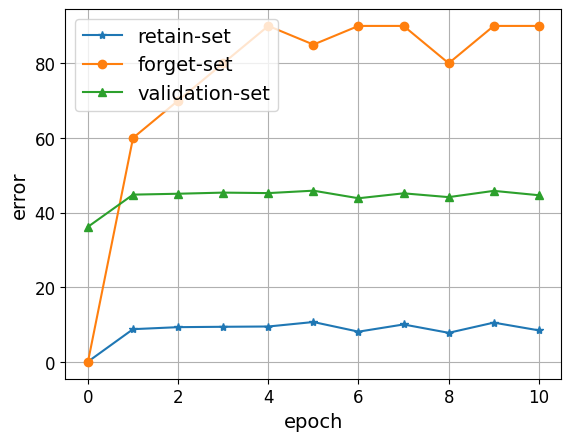

Forgetting by SCRUB:


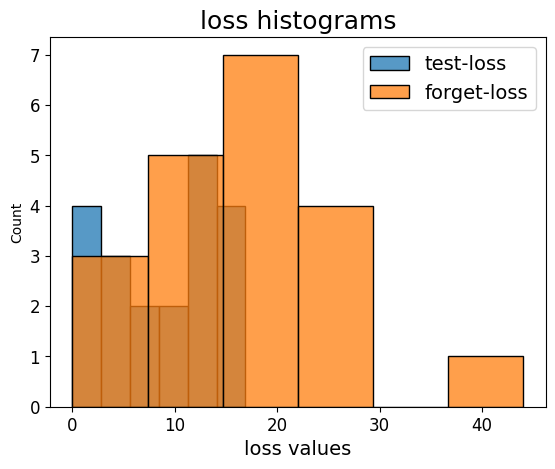

/tmp/ipykernel_4082370/1560673829.py:20: RuntimeWarning: invalid value encountered in scalar divide
  TNR = TN/(TN+FP)
/tmp/ipykernel_4082370/1560673829.py:26: RuntimeWarning: invalid value encountered in scalar divide
  FPR = FP/(FP+TN)


16.886883 2.1695856e-05
44.037766 2.324554e-05
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:nan, FNR:0.50, FP0.00, TN0.00, TP2.00, FN2.00


Bad-T ->	Full test error: 43.42	Forget error: 90.00	Retain error: 8.45	Valid error: 44.65	Fine-tune time: 1 steps	MIA: 0.70±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_2
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_2_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_2
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_2_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [475, 3473, 8787, 13127, 18401, 18522, 20569, 21011, 23355, 23656, 28495, 29022, 32126, 32335, 32479, 33445, 33667, 36143, 36303, 39741]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and 

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.752 Acc@5 99.985
loss: 7.08	 train_acc: 99.75238037109375
Epoch: [2][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.8427 (3.8427)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.737 Acc@5 99.995
loss: 2.66	 train_acc: 99.73737335205078
Epoch: [3][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 12.0275 (12.0275)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.707 Acc@5 99.987
loss: 2.20	 train_acc: 99.70735931396484
Epoch: [4][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 2.2266 (2.2266)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.722 Acc@5 99.990
loss: 1.93	 train_acc: 99.72236633300781
Epoch: [5][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 1.9233 (1.9233)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.725 Acc@5 99.977
loss: 1.79	 train_acc: 99.72486114501953
Epoch: [6][0/313]	Time 0.059 (0.059)	Data 0.026 (0.026)	Loss 1.9567 (1.9567)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.702 Acc@5 99.

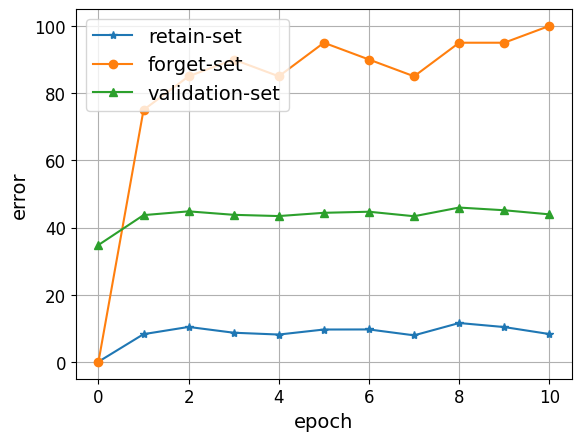

Forgetting by SCRUB:


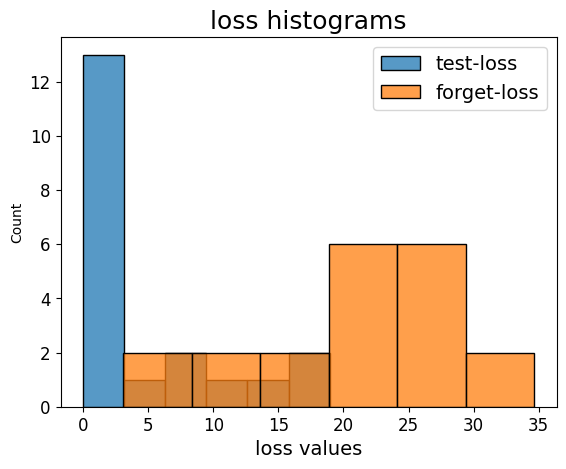

18.943079 1.537788e-05
34.638443 3.1041625
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00


Bad-T ->	Full test error: 44.24	Forget error: 100.00	Retain error: 8.30	Valid error: 43.92	Fine-tune time: 1 steps	MIA: 0.80±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_3
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_3_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_3
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_3_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [248, 2840, 3276, 6736, 7995, 9800, 15041, 16972, 19524, 20059, 20083, 20727, 21072, 24180, 24188, 30467, 31112, 34535, 35239, 39193]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and ve

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.722 Acc@5 99.987
loss: 6.37	 train_acc: 99.72236633300781
Epoch: [2][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 4.2913 (4.2913)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.710 Acc@5 99.987
loss: 2.15	 train_acc: 99.70985412597656
Epoch: [3][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 7.1061 (7.1061)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.707 Acc@5 99.985
loss: 1.93	 train_acc: 99.70735931396484
Epoch: [4][0/313]	Time 0.061 (0.061)	Data 0.026 (0.026)	Loss 1.9209 (1.9209)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.780 Acc@5 99.987
loss: 1.77	 train_acc: 99.77989196777344
Epoch: [5][0/313]	Time 0.060 (0.060)	Data 0.026 (0.026)	Loss 1.9488 (1.9488)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.722 Acc@5 99.982
loss: 1.78	 train_acc: 99.72236633300781
Epoch: [6][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 4.2116 (4.2116)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.710 Acc@5 99.990


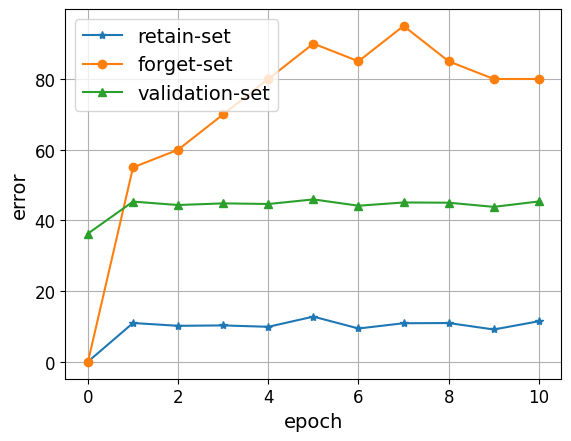

Forgetting by SCRUB:


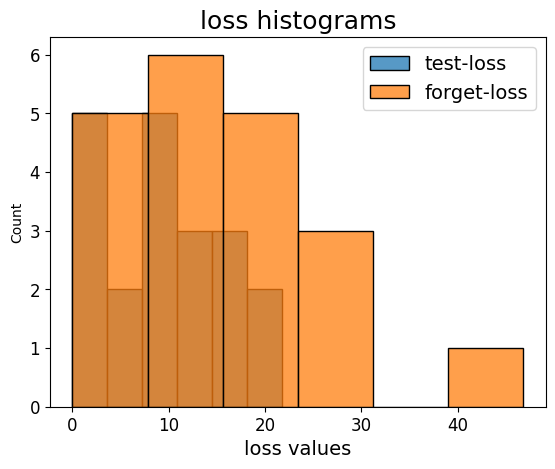

/tmp/ipykernel_4082370/1560673829.py:18: RuntimeWarning: invalid value encountered in scalar divide
  TPR = TP/(TP+FN)
/tmp/ipykernel_4082370/1560673829.py:28: RuntimeWarning: invalid value encountered in scalar divide
  FNR = FN/(TP+FN)


21.793013 0.001170784
46.81903 5.6028207e-06
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.50, FNR:nan, FP2.00, TN2.00, TP0.00, FN0.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00


Bad-T ->	Full test error: 45.06	Forget error: 80.00	Retain error: 11.50	Valid error: 45.37	Fine-tune time: 1 steps	MIA: 0.70±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_4
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_4_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_4
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_4_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [2069, 3752, 4123, 6256, 7088, 8986, 12019, 13264, 13554, 21033, 23895, 25027, 26777, 30742, 30932, 32585, 35777, 36043, 36591, 39618]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and v

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.787 Acc@5 99.990
loss: 6.80	 train_acc: 99.78739929199219
Epoch: [2][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 3.0688 (3.0688)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.777 Acc@5 99.997
loss: 2.38	 train_acc: 99.77738952636719
Epoch: [3][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 5.3702 (5.3702)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.745 Acc@5 99.993
loss: 2.24	 train_acc: 99.744873046875
Epoch: [4][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.4761 (2.4761)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.732 Acc@5 99.993
loss: 1.91	 train_acc: 99.73236846923828
Epoch: [5][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 2.2289 (2.2289)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.785 Acc@5 99.993
loss: 1.67	 train_acc: 99.78489685058594
Epoch: [6][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 10.4226 (10.4226)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.705 Acc@5 99.98

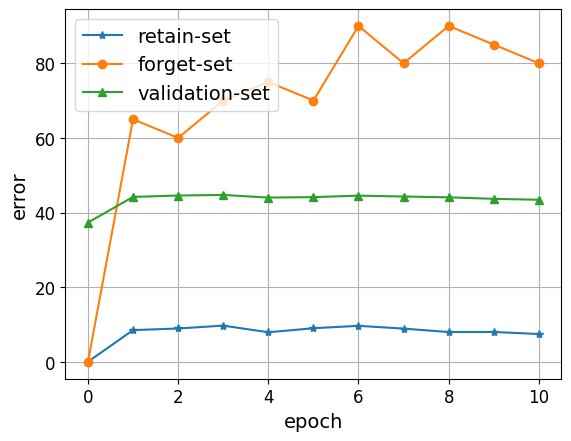

Forgetting by SCRUB:


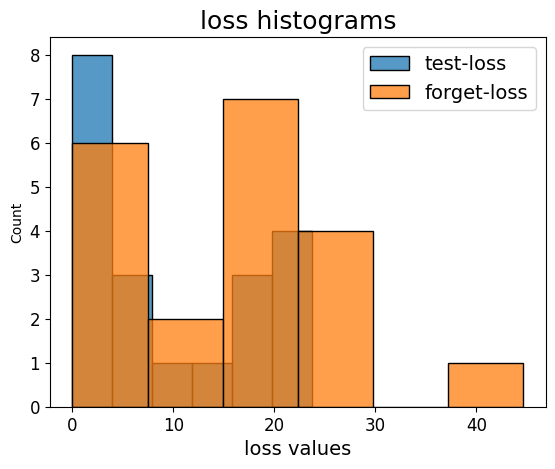

/tmp/ipykernel_4082370/1560673829.py:18: RuntimeWarning: invalid value encountered in scalar divide
  TPR = TP/(TP+FN)
/tmp/ipykernel_4082370/1560673829.py:28: RuntimeWarning: invalid value encountered in scalar divide
  FNR = FN/(TP+FN)


23.74989 0.0006746162
44.646137 0.00090689055
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:0.50, FNR:nan, FP2.00, TN2.00, TP0.00, FN0.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00


Bad-T ->	Full test error: 43.32	Forget error: 80.00	Retain error: 7.47	Valid error: 43.44	Fine-tune time: 1 steps	MIA: 0.65±0.1
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_5
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_5_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_5
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_5_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [368, 728, 5013, 5642, 6089, 6570, 6929, 9240, 10258, 12662, 18261, 19946, 25378, 27940, 29249, 31146, 31970, 32339, 32577, 35781]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and verifi

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.782 Acc@5 99.985
loss: 7.16	 train_acc: 99.78239440917969
Epoch: [2][0/313]	Time 0.061 (0.061)	Data 0.026 (0.026)	Loss 11.0591 (11.0591)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.717 Acc@5 99.980
loss: 2.85	 train_acc: 99.71736145019531
Epoch: [3][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 3.1920 (3.1920)	Acc@1 98.438 (98.438)	Acc@5 100.000 (100.000)
 * Acc@1 99.770 Acc@5 99.985
loss: 2.11	 train_acc: 99.76988983154297
Epoch: [4][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 1.8502 (1.8502)	Acc@1 98.438 (98.438)	Acc@5 100.000 (100.000)
 * Acc@1 99.722 Acc@5 99.985
loss: 1.92	 train_acc: 99.72236633300781
Epoch: [5][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.1626 (2.1626)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.760 Acc@5 99.980
loss: 1.74	 train_acc: 99.75988006591797
Epoch: [6][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.8267 (2.8267)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.760 Acc@5 99.987


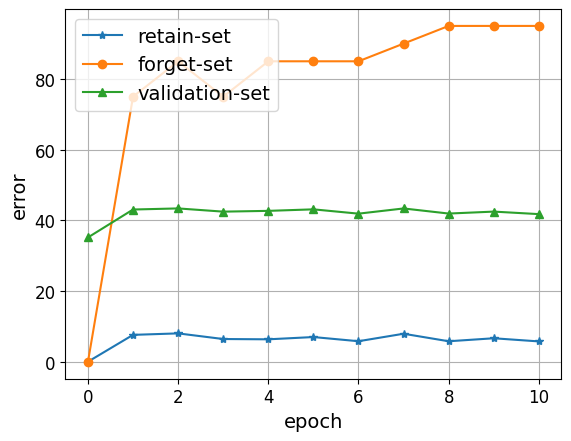

Forgetting by SCRUB:


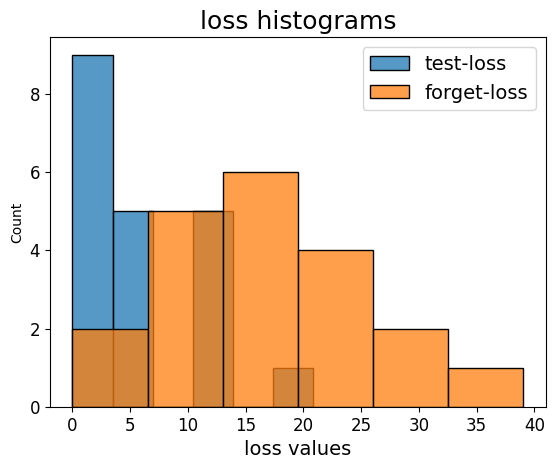

20.873783 0.0018241447
39.04638 0.00015615197
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00


Bad-T ->	Full test error: 41.54	Forget error: 95.00	Retain error: 5.80	Valid error: 41.79	Fine-tune time: 1 steps	MIA: 0.90±0.1
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_6
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_6_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_6
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_6_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [5401, 5577, 9003, 12332, 12754, 13694, 16721, 18614, 19921, 20625, 20893, 23368, 24594, 28200, 30811, 32520, 33019, 34289, 34587, 35548]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.757 Acc@5 99.982
loss: 7.37	 train_acc: 99.75737762451172
Epoch: [2][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.7648 (3.7648)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.735 Acc@5 99.982
loss: 2.42	 train_acc: 99.73487091064453
Epoch: [3][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 2.4446 (2.4446)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.767 Acc@5 99.985
loss: 2.16	 train_acc: 99.76738739013672
Epoch: [4][0/313]	Time 0.063 (0.063)	Data 0.028 (0.028)	Loss 4.0389 (4.0389)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.685 Acc@5 99.977
loss: 1.99	 train_acc: 99.68484497070312
Epoch: [5][0/313]	Time 0.062 (0.062)	Data 0.027 (0.027)	Loss 12.6062 (12.6062)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.640 Acc@5 99.982
loss: 1.74	 train_acc: 99.63982391357422
Epoch: [6][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 1.9487 (1.9487)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.712 Acc@5 9

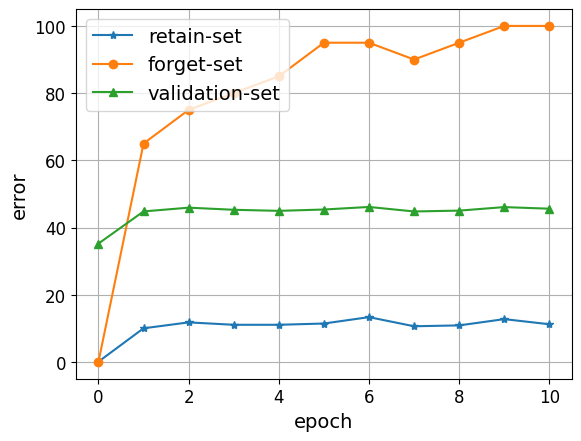

Forgetting by SCRUB:


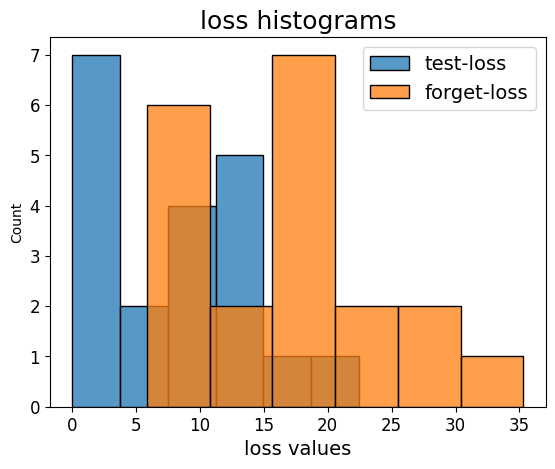

22.42983 0.0054307072
35.312225 5.8421583
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00


Bad-T ->	Full test error: 45.80	Forget error: 100.00	Retain error: 11.21	Valid error: 45.60	Fine-tune time: 1 steps	MIA: 0.70±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_7
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_7_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_7
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_7_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [759, 1602, 5830, 6063, 9754, 12114, 12571, 13518, 13561, 16494, 16830, 17410, 23318, 23637, 24477, 25007, 27192, 28154, 32225, 32360]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and 

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.750 Acc@5 99.987
loss: 6.62	 train_acc: 99.7498779296875
Epoch: [2][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.0581 (3.0581)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.702 Acc@5 99.987
loss: 2.54	 train_acc: 99.70235443115234
Epoch: [3][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 16.3634 (16.3634)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.682 Acc@5 99.985
loss: 2.29	 train_acc: 99.68234252929688
Epoch: [4][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 1.9157 (1.9157)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.712 Acc@5 99.987
loss: 1.85	 train_acc: 99.71235656738281
Epoch: [5][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 6.3078 (6.3078)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.757 Acc@5 99.990
loss: 1.81	 train_acc: 99.75737762451172
Epoch: [6][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 1.9300 (1.9300)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.665 Acc@5 99.982
l

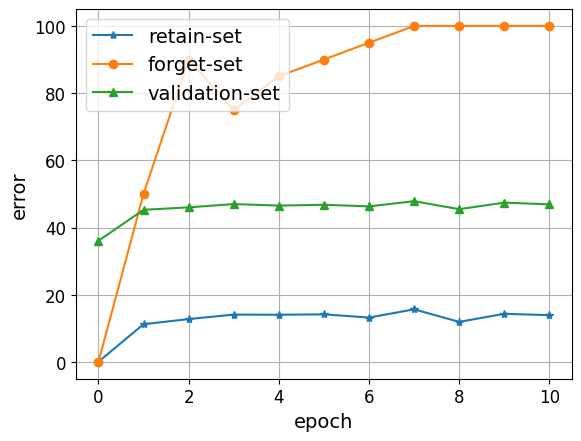

Forgetting by SCRUB:


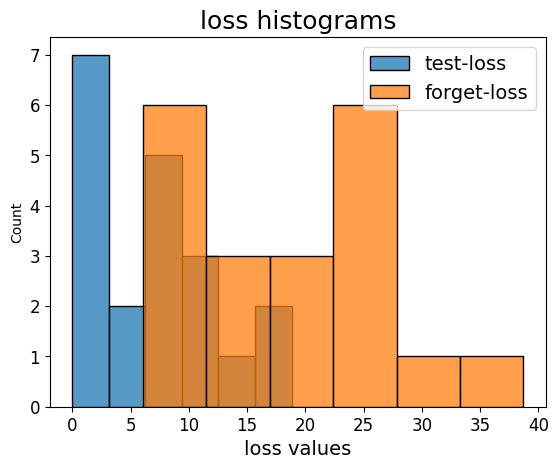

/tmp/ipykernel_4082370/1560673829.py:20: RuntimeWarning: invalid value encountered in scalar divide
  TNR = TN/(TN+FP)
/tmp/ipykernel_4082370/1560673829.py:26: RuntimeWarning: invalid value encountered in scalar divide
  FPR = FP/(FP+TN)


18.811974 0.0003255076
38.720345 6.0454025
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:nan, FNR:0.50, FP0.00, TN0.00, TP2.00, FN2.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00


Bad-T ->	Full test error: 46.27	Forget error: 100.00	Retain error: 13.91	Valid error: 46.89	Fine-tune time: 1 steps	MIA: 0.65±0.1
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_8
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_8_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_8
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_8_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [3001, 6374, 6442, 7099, 12112, 12661, 13034, 13763, 16911, 17480, 23498, 27483, 28193, 28484, 28857, 30291, 32983, 34601, 37080, 39224]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded an

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.680 Acc@5 99.980
loss: 7.05	 train_acc: 99.67984008789062
Epoch: [2][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 2.8371 (2.8371)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.705 Acc@5 99.982
loss: 2.60	 train_acc: 99.7048568725586
Epoch: [3][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.4387 (3.4387)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.652 Acc@5 99.980
loss: 2.17	 train_acc: 99.65232849121094
Epoch: [4][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 10.5305 (10.5305)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.612 Acc@5 99.965
loss: 1.98	 train_acc: 99.6123046875
Epoch: [5][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.0563 (2.0563)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.642 Acc@5 99.982
loss: 1.74	 train_acc: 99.64232635498047
Epoch: [6][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 1.6475 (1.6475)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.660 Acc@5 99.982
los

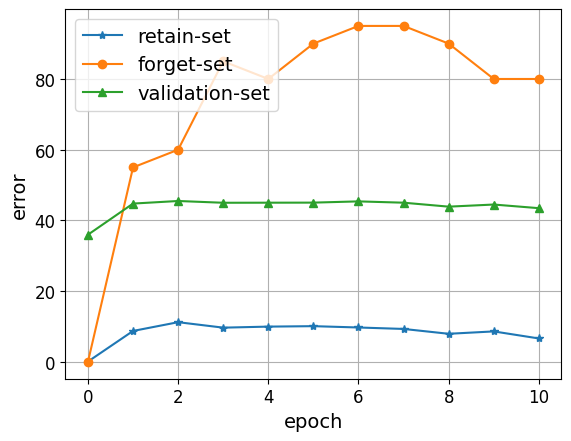

Forgetting by SCRUB:


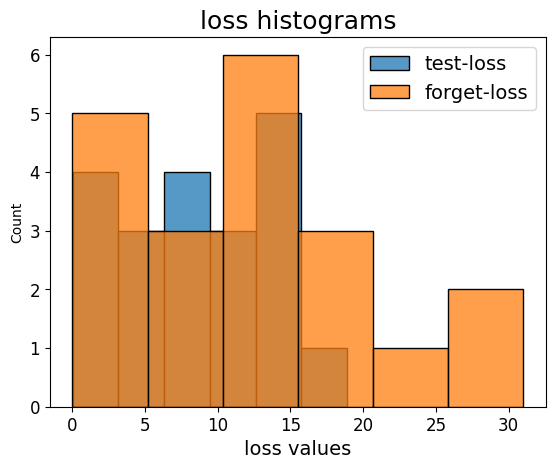

18.889542 0.0096294675
31.019127 0.0005464253
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.67, FNR:1.00, FP2.00, TN1.00, TP0.00, FN1.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00


Bad-T ->	Full test error: 42.90	Forget error: 80.00	Retain error: 6.63	Valid error: 43.47	Fine-tune time: 1 steps	MIA: 0.55±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_9
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_9_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_9
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_9_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [2, 366, 664, 5778, 7262, 7486, 12194, 12429, 19583, 19989, 20067, 21068, 24419, 24887, 25783, 27020, 30900, 31003, 36664, 38397]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded and verifie

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 90.235 Acc@5 99.210
loss: 8.69	 train_acc: 90.23512268066406
Epoch: [2][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 3.7077 (3.7077)	Acc@1 92.188 (92.188)	Acc@5 99.219 (99.219)
 * Acc@1 89.777 Acc@5 99.147
loss: 2.81	 train_acc: 89.77738952636719
Epoch: [3][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 12.2649 (12.2649)	Acc@1 89.844 (89.844)	Acc@5 98.438 (98.438)
 * Acc@1 89.147 Acc@5 99.052
loss: 2.67	 train_acc: 89.1470718383789
Epoch: [4][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.0014 (3.0014)	Acc@1 85.938 (85.938)	Acc@5 97.656 (97.656)
 * Acc@1 89.790 Acc@5 99.095
loss: 2.32	 train_acc: 89.7898941040039
Epoch: [5][0/313]	Time 0.062 (0.062)	Data 0.028 (0.028)	Loss 2.0251 (2.0251)	Acc@1 88.281 (88.281)	Acc@5 97.656 (97.656)
 * Acc@1 90.320 Acc@5 99.167
loss: 1.88	 train_acc: 90.32015991210938
Epoch: [6][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.0381 (2.0381)	Acc@1 92.969 (92.969)	Acc@5 100.000 (100.000)
 * Acc@1 89.757 Acc@5 99.100
loss: 1.94	 tr

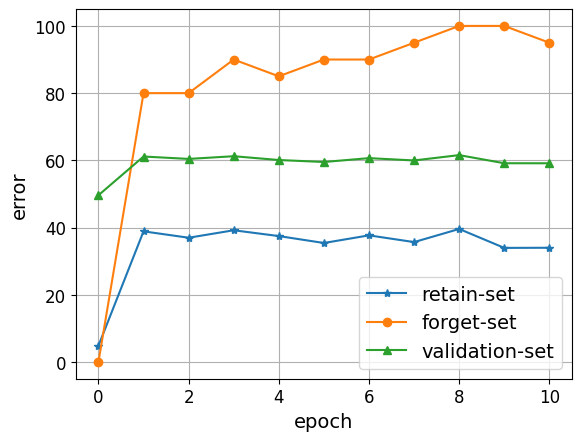

Forgetting by SCRUB:


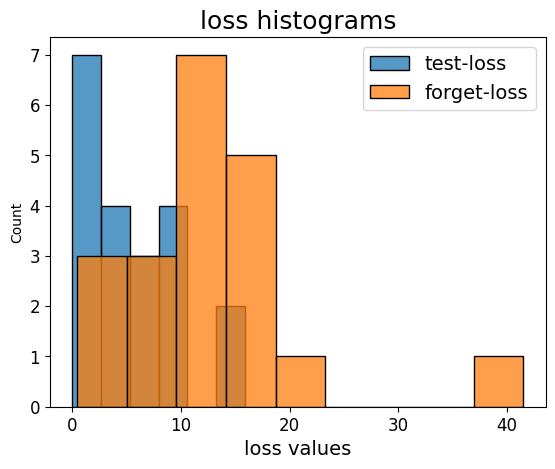

/tmp/ipykernel_4082370/1560673829.py:20: RuntimeWarning: invalid value encountered in scalar divide
  TNR = TN/(TN+FP)
/tmp/ipykernel_4082370/1560673829.py:26: RuntimeWarning: invalid value encountered in scalar divide
  FPR = FP/(FP+TN)


15.880435 0.0004997197
41.517143 0.43999982
FPR:nan, FNR:0.50, FP0.00, TN0.00, TP2.00, FN2.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00
FPR:0.00, FNR:0.33, FP0.00, TN1.00, TP2.00, FN1.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00


Bad-T ->	Full test error: 59.04	Forget error: 95.00	Retain error: 33.98	Valid error: 59.12	Fine-tune time: 1 steps	MIA: 0.70±0.2
Checkpoint name: cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_10
[Logging in cifar100_vgg16_1_0_forget_None_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_10_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 100
Pure training time: 0 sec
Checkpoint name: cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_10
[Logging in cifar100_vgg16_1_0_forget_[0]_num_20_lr_0_01_bs_64_ls_ce_wd_0_0001_seed_10_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Replacing indexes [251, 2033, 2120, 3401, 5725, 5818, 10733, 11596, 11697, 12811, 13944, 18030, 19364, 22096, 27974, 28011, 28677, 31229, 34216, 36602]
Number of Classes: 100
Pure training time: 0 sec
Files already downloaded an

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 99.737 Acc@5 99.990
loss: 7.09	 train_acc: 99.73737335205078
Epoch: [2][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.8447 (2.8447)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.727 Acc@5 99.990
loss: 2.23	 train_acc: 99.72736358642578
Epoch: [3][0/313]	Time 0.060 (0.060)	Data 0.027 (0.027)	Loss 2.3935 (2.3935)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.685 Acc@5 99.987
loss: 1.97	 train_acc: 99.68484497070312
Epoch: [4][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 2.2161 (2.2161)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.667 Acc@5 99.987
loss: 1.86	 train_acc: 99.6673355102539
Epoch: [5][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 3.1190 (3.1190)	Acc@1 97.656 (97.656)	Acc@5 100.000 (100.000)
 * Acc@1 99.682 Acc@5 99.990
loss: 1.67	 train_acc: 99.68234252929688
Epoch: [6][0/313]	Time 0.061 (0.061)	Data 0.027 (0.027)	Loss 2.1928 (2.1928)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.710 Acc@5 99.987
los

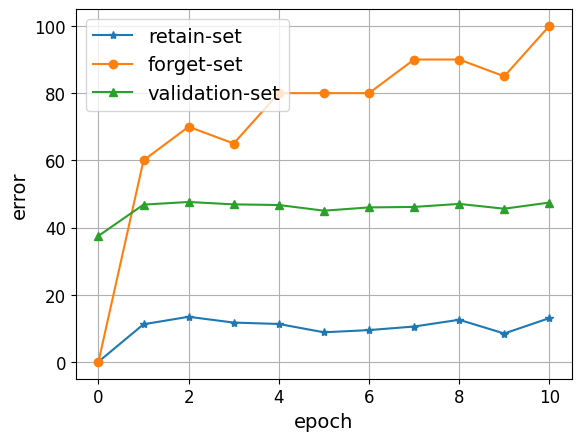

Forgetting by SCRUB:


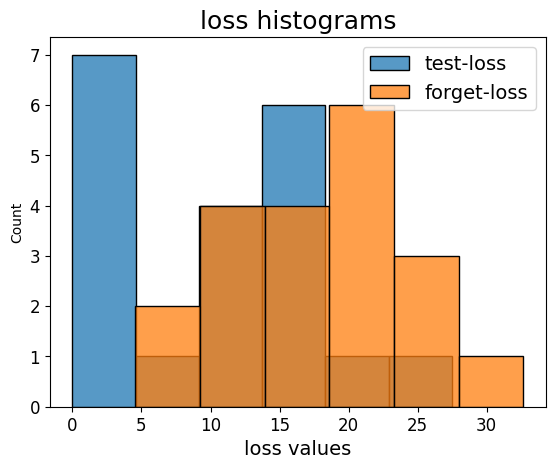

/tmp/ipykernel_4082370/1560673829.py:20: RuntimeWarning: invalid value encountered in scalar divide
  TNR = TN/(TN+FP)
/tmp/ipykernel_4082370/1560673829.py:26: RuntimeWarning: invalid value encountered in scalar divide
  FPR = FP/(FP+TN)


27.47396 0.00020621081
32.65697 4.5422325
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:nan, FNR:0.50, FP0.00, TN0.00, TP2.00, FN2.00
FPR:0.50, FNR:0.50, FP1.00, TN1.00, TP1.00, FN1.00
FPR:0.33, FNR:0.00, FP1.00, TN2.00, TP1.00, FN0.00
FPR:0.00, FNR:0.00, FP0.00, TN2.00, TP2.00, FN0.00


Bad-T ->	Full test error: 47.25	Forget error: 100.00	Retain error: 13.04	Valid error: 47.43	Fine-tune time: 1 steps	MIA: 0.65±0.2


In [20]:
seeds = [1,2,3,4,5,6,7,8,9,10]
chkpt = "checkpoints/cifar100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt"
forget_class = '0'
forget_num = 20
dataset = 'cifar100'
modelname = 'vgg16'
dataroot = '../image_data/cifar100'
filters = 1.0


errors = []
for s in seeds:

    %run train.py --dataset $dataset --model $modelname --dataroot=$dataroot --filters $filters --lr 0.01 \
    --disable-bn --weight-decay 0.0001 --batch-size 64 --epochs 0 --seed $s

    %run train.py --dataset $dataset --model $modelname --dataroot=$dataroot --filters $filters --lr 0.01 \
    --disable-bn --weight-decay 0.0001 --batch-size 64 --epochs 0 \
    --forget-class $forget_class --num-to-forget $forget_num --seed $s


    log_dict={}
    training_epochs=30
    model0 = copy.deepcopy(model)
    model_initial = copy.deepcopy(model)

    arch = args.model 
    filters=args.filters
    arch_filters = arch +'_'+ str(filters).replace('.','_')
    augment = False
    dataset = args.dataset
    class_to_forget = args.forget_class
    init_checkpoint = f"checkpoints/{args.name}_init.pt"
    num_classes=args.num_classes
    num_to_forget = args.num_to_forget
    num_total = len(train_loader.dataset)
    num_to_retain = num_total - forget_num
    seed = args.seed
    unfreeze_start = None

    learningrate=f"lr_{str(args.lr).replace('.','_')}"
    batch_size=f"_bs_{str(args.batch_size)}"
    lossfn=f"_ls_{args.lossfn}"
    wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
    seed_name=f"_seed_{args.seed}_"

    num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
    unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
    augment_tag = '' if not augment else f'augment_'

    m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
    m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

    model.load_state_dict(torch.load(m_name))
    model0.load_state_dict(torch.load(m0_name))
    model_initial.load_state_dict(torch.load(init_checkpoint))
    
    bad_teacher = model_dict[args.model](num_classes=num_classes).to(args.device)
    teacher = copy.deepcopy(model)
    student = copy.deepcopy(model)

    model.cuda()
    model0.cuda()
    
    for p in model.parameters():
        p.data0 = p.data.clone()
    for p in model0.parameters():
        p.data0 = p.data.clone()
    
    log_dict={}
    log_dict['args']=args
    args.retain_bs = 128#128
    args.forget_bs = 16#64

    train_loader_full, valid_loader_full, test_loader_full, _ = datasets.get_loaders(args.dataset, batch_size=args.batch_size, seed=s, root=args.dataroot, augment=False, shuffle=True)
    marked_loader, _, _, _ = datasets.get_loaders(args.dataset, class_to_replace=args.forget_class, num_indexes_to_replace=args.num_to_forget, only_mark=True, batch_size=1, seed=s, root=args.dataroot, augment=False, shuffle=True)

    forget_dataset = copy.deepcopy(marked_loader.dataset)
    marked = forget_dataset.targets < 0
    forget_dataset.data = forget_dataset.data[marked]
    forget_dataset.targets = - forget_dataset.targets[marked] - 1
    #forget_loader = torch.utils.data.DataLoader(forget_dataset, batch_size=args.forget_bs,num_workers=0,pin_memory=True,shuffle=True)
    forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

    retain_dataset = copy.deepcopy(marked_loader.dataset)
    marked = retain_dataset.targets >= 0
    retain_dataset.data = retain_dataset.data[marked]
    retain_dataset.targets = retain_dataset.targets[marked]
    #retain_loader = torch.utils.data.DataLoader(retain_dataset, batch_size=args.retain_bs,num_workers=0,pin_memory=True,shuffle=True)
    retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

    assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

    
    model_ft = copy.deepcopy(model)
    args.ft_lr = 0.04
    args.ft_epochs = 10
    
    
    print ("Forgetting by Fine-tuneing:")
    #finetune(model_ft, retain_loader, epochs=args.ft_epochs, quiet=True, lr=args.ft_lr)
    print ("Forgetting by NegGrad:")
    #model_ng = negative_grad(model, retain_dataset, forget_dataset, quiet=True, args=args)
    print ("Forgetting by CFK:")
    #model_cfk = cfk_unlearn(model)
    print ("Forgetting by EUK:")
    #model_euk = euk_unlearn(model, model_initial)
    print ('Forgetting by Bad-T')
    model_bt = badt(teacher, bad_teacher, student)
    print("Forgetting by SCRUB:")
    #model_s, model_s_final = scrub(teacher, student)

            
    readouts = {}
    #_,_=activations_predictions(copy.deepcopy(model),forget_loader,'Original_Model_D_f')
    thresh=0#og_dict['Original_Model_D_f_loss']+1e-5
    #readouts["Original"] = all_readouts(copy.deepcopy(model),thresh,'Original',seed)
    #readouts["Retrain"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain',seed)
    #readouts['Finetune'] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune',seed)
    #readouts["NegGrad"] = all_readouts(copy.deepcopy(model_ng),thresh,'NegGrad',seed)
    #readouts["CFK"] = all_readouts(copy.deepcopy(model_cfk),thresh,'CFK',seed)
    #readouts["EUK"] = all_readouts(copy.deepcopy(model_euk),thresh,'EUK',seed)
    readouts["Bad-T"] = all_readouts(copy.deepcopy(model_bt),thresh,'Bad-T',seed)
    #readouts["SCRUB+R"] = all_readouts(copy.deepcopy(model_s),thresh,'SCRUB+R',seed)
    #readouts["SCRUB"] = all_readouts(copy.deepcopy(model_s_final),thresh,'SCRUB',seed)
    
    
    del model
    del model0
    #del model_ft
    #del model_ng
    #del model_euk
    #del model_cfk
    del model_bt
    #del model_s
    #del model_s_final
    del retain_loader
    del forget_loader
    del test_loader_full
    del train_loader_full

    errors.append(readouts)

In [21]:
import scipy.stats as st
import math
tes = {}
res = {}
fes = {}
ves = {}
rlt = {}
MIA = {}
for key in errors[0].keys():
    tes[key] = [errors[i][key]['test_error'] for i in range(len(errors))]
    res[key] = [errors[i][key]['retain_error'] for i in range(len(errors))]
    fes[key] = [errors[i][key]['forget_error'] for i in range(len(errors))]
    ves[key] = [errors[i][key]['val_error'] for i in range(len(errors))]
    rlt[key] = [errors[i][key]['retrain_time'] for i in range(len(errors))]
    MIA[key] = [errors[i][key]['MIA']*100 for i in range(len(errors))]
    
    tes_int = st.t.interval(alpha=0.95, df=len(tes[key])-1, loc=np.mean(tes[key]), scale=st.sem(tes[key]))
    res_int = st.t.interval(alpha=0.95, df=len(res[key])-1, loc=np.mean(res[key]), scale=st.sem(res[key]))
    fes_int = st.t.interval(alpha=0.95, df=len(fes[key])-1, loc=np.mean(fes[key]), scale=st.sem(fes[key]))
    ves_int = st.t.interval(alpha=0.95, df=len(ves[key])-1, loc=np.mean(ves[key]), scale=st.sem(ves[key]))
    mia_int = st.t.interval(alpha=0.95, df=len(MIA[key])-1, loc=np.mean(MIA[key]), scale=st.sem(MIA[key]))
    print ("{}  \t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}".format(
        key,
        np.mean(tes[key]), (tes_int[1] - tes_int[0])/2,
        np.mean(fes[key]), (fes_int[1] - fes_int[0])/2,
        np.mean(res[key]), (res_int[1] - res_int[0])/2,
        np.mean(ves[key]), (ves_int[1] - ves_int[0])/2,
        np.mean(MIA[key]), (mia_int[1] - mia_int[0])/2))

Bad-T  	45.88±3.53	92.00±6.35	12.03±5.85	46.17±3.47	70.00±6.74


/tmp/ipykernel_4082370/2762650683.py:17: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  tes_int = st.t.interval(alpha=0.95, df=len(tes[key])-1, loc=np.mean(tes[key]), scale=st.sem(tes[key]))
/tmp/ipykernel_4082370/2762650683.py:18: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  res_int = st.t.interval(alpha=0.95, df=len(res[key])-1, loc=np.mean(res[key]), scale=st.sem(res[key]))
/tmp/ipykernel_4082370/2762650683.py:19: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  fes_int = st.t.interval(alpha=0.95, df=len(fes[key])-1, loc=np.mean(fes[key])